# Exercise 8: BLOBs and SIFT features

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy.ndimage
from skimage import color
import skimage

In [2]:
def gaussian1DKernel(sigma):
    '''
    Computes kernels of Gaussian and its derivatives.
    Parameters
    ----------
    t : float
        Vairance - t.

    Returns
    -------
    g : numpy array
        Gaussian.
    dg : numpy array
        First order derivative of Gaussian.

    '''

    kSize = 5
    x = np.arange(int(-np.ceil(sigma*kSize)), int(np.ceil(sigma*kSize))+1)
    x = np.reshape(x,(-1,1))
    g = np.exp(-x**2/(2*sigma**2))
    g = g/np.sum(g)
    dg = -x/sigma**2*g
    return g, dg

## BLOB detector

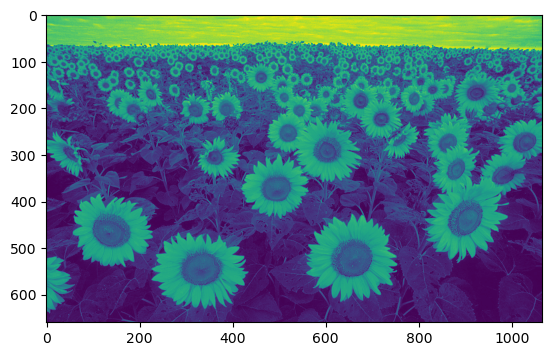

(660, 1066)


In [3]:
im = cv2.imread('sunflowers.jpg')[:,:,::-1]
im = im.astype(float).mean(2)/255
plt.imshow(im)
plt.show()

print(im.shape)

### Exercise 8.1

In [4]:
def scaleSpaced(im, sigma, n):
    im_scales = []
    for i in range(n+1):
        g, dg = gaussian1DKernel(sigma*2**i)
        I = scipy.ndimage.convolve(scipy.ndimage.convolve(im,g),g.T)
        im_scales.append(I)
    return im_scales 

(660, 1066)
(660, 1066)
(660, 1066)
(660, 1066)
(660, 1066)
(660, 1066)
(660, 1066)


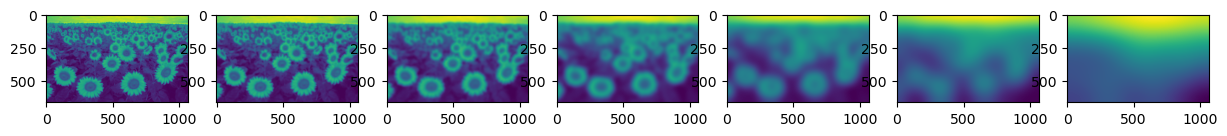

In [5]:
im_scales = scaleSpaced(im, 2, 7)

fig, ax = plt.subplots(1,7, figsize=(15,2))
for i in range(7):
    ax[i].imshow(im_scales[i])
    print(im_scales[i].shape)
plt.show()

### Exercise 8.2

In [6]:
def differenceOfGaussians(im, sigma, n):
    DoG = []
    im_scales = scaleSpaced(im, sigma, n)
    for i in range(n):
        diff = im_scales[i+1]-im_scales[i]
        DoG.append(diff)
    return DoG

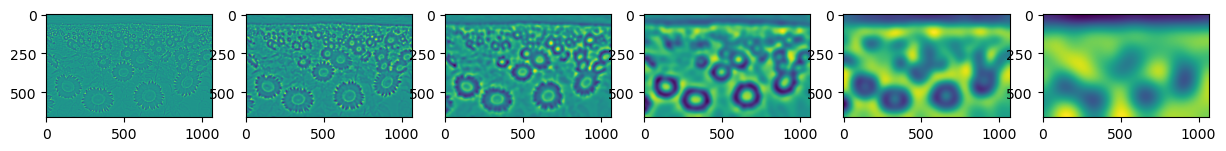

In [7]:
DoG = differenceOfGaussians(im, 2, 7)

fig, ax = plt.subplots(1,6, figsize=(15,2))
for i in range(6):
    ax[i].imshow(DoG[i])
plt.show()

### Exercise 8.3

In [8]:
def nonmaxSuppression(im, tau):
    # thresholding
    im[abs(im)<tau] = 0
    
    #
    maxima = np.zeros(im.shape)
    
    down = im[:-1,:] - im[1:,:]
    down = np.vstack((down,np.zeros((1,im.shape[1]))))
    maxima[down > 0] += 1
    
    up = im[1:,:] - im[:-1,:]
    up = np.vstack((np.zeros((1,im.shape[1])),up))
    maxima[up > 0] += 1
    
    right = im[:,:-1] - im[:,1:]
    right = np.hstack((right, np.zeros((im.shape[0],1))))
    maxima[right > 0] += 1
    
    left = im[:,1:] - im[:,:-1]
    left = np.hstack((np.zeros((im.shape[0],1)),left))
    maxima[left > 0] += 1
    
    downright = im[:-1,:-1] - im[1:,1:]
    downright = np.vstack((downright,np.zeros((1,im.shape[1]-1))))
    downright = np.hstack((downright, np.zeros((im.shape[0],1))))
    maxima[downright > 0] += 1
    
    downleft = im[:-1,1:] - im[1:,:-1]
    downleft = np.vstack((downleft,np.zeros((1,im.shape[1]-1))))
    downleft = np.hstack((np.zeros((im.shape[0],1)),downleft))
    maxima[downleft > 0] += 1
    
    upright = im[1:,:-1] - im[:-1,1:]
    upright = np.vstack((np.zeros((1,im.shape[1]-1)),upright))
    upright = np.hstack((upright, np.zeros((im.shape[0],1))))
    maxima[upright > 0] += 1
    
    upleft = im[1:,1:] - im[:-1,:-1]
    upleft = np.vstack((np.zeros((1,im.shape[1]-1)),upleft))
    upleft = np.hstack((np.zeros((im.shape[0],1)),upleft))
    maxima[upleft > 0] += 1
    
    c = np.where(maxima>7)
    
    return c

In [9]:
def detectBlobs(im, sigma, n, tau):
    blobs= []
    DoG = differenceOfGaussians(im, sigma, n)
    
    MaxDoG = []
    MaxCoord = []
    for i in range(n):
        filtered = cv2.dilate(abs(DoG[i]), np.ones((3,3)))
        MaxDoG.append(filtered)   
        temp = nonmaxSuppression(DoG[i], tau)
        MaxCoord.append(temp)
    
    for k in range(len(MaxCoord[0][0])):
        x = MaxCoord[0][0][k]
        y = MaxCoord[0][1][k]
        if im[x,y] > MaxDoG[1][x,y]:
            blobs.append((x,y,sigma*2**0))
            
    for i in range(1,n-1):
        for k in range(len(MaxCoord[i][0])):
            x = MaxCoord[i][0][k]
            y = MaxCoord[i][1][k]
            if im[x,y] > MaxDoG[i-1][x,y] and im[x,y] > MaxDoG[i+1][x,y]:
                blobs.append((x,y,sigma*2**i))
            
    return blobs

In [10]:
%matplotlib qt 

im = cv2.imread('sunflowers.jpg')[:,:,::-1]
im = im.astype(float).mean(2)/255
blobsmax = detectBlobs(im, 2, 7, 0.1)
blobsmin = detectBlobs(-im, 2, 7, 0.1)
color = (255, 255, 255)
#plt.imshow(im)
for blob in blobsmax:
    #plt.plot(blob[1], blob[0], 'r.')
    im = cv2.circle(im, (blob[1],blob[0]), blob[2], color)
for blob in blobsmin:
    #plt.plot(blob[1], blob[0], 'r.')
    im = cv2.circle(im, (blob[1],blob[0]), blob[2], color)
cv2.imshow('IMAGE', im)

## Using SIFT features

In [4]:
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp

### Exercise 8.4

In [49]:
def transformIm(im, ang, sc):
    imr = scipy.ndimage.rotate(scipy.ndimage.zoom(im1,sc),ang,reshape=False)[50:-50,50:-50]
    return imr

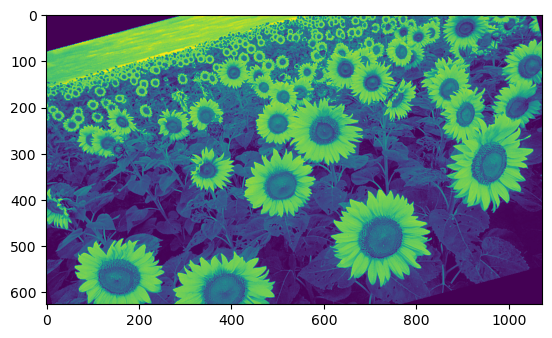

In [55]:
im1 = cv2.imread('sunflowers.jpg',cv2.IMREAD_GRAYSCALE)
im2 = transformIm(im, 15, 1.1)
plt.imshow(im2)
plt.show()

In [56]:
thres = 0.1

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
    
for m,n in matches:
    if m.distance/(n.distance+10e-10) < thres:
        good_matches.append([m])
    
# Find coordinates
pts_im1 = [kp1[m[0].queryIdx].pt for m in good_matches]
pts_im1 = np.array(pts_im1, dtype=np.float32).T
pts_im2 = [kp2[m[0].trainIdx].pt for m in good_matches]
pts_im2 = np.array(pts_im2, dtype=np.float32).T

In [57]:
good_matches

[[< cv2.DMatch 0x7fa1e94e8450>],
 [< cv2.DMatch 0x7fa1d2e86670>],
 [< cv2.DMatch 0x7fa1e909d870>],
 [< cv2.DMatch 0x7fa1e90a1bb0>],
 [< cv2.DMatch 0x7fa1e90a33f0>],
 [< cv2.DMatch 0x7fa1d13298b0>],
 [< cv2.DMatch 0x7fa1d13298f0>],
 [< cv2.DMatch 0x7fa1d1335470>],
 [< cv2.DMatch 0x7fa1d13358f0>],
 [< cv2.DMatch 0x7fa1d133a830>],
 [< cv2.DMatch 0x7fa1d1e385f0>]]

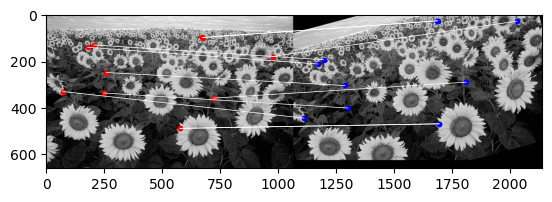

In [54]:
r1,c1 = im1.shape
r2,c2 = im2.shape
n_row = np.maximum(r1, r2)
n_col = c1 + c2
im_comp = np.zeros((n_row,n_col))
im_comp[:r1,:c1] = im1
im_comp[:r2,c1:(c1+c2)] = im2
    
fig,ax = plt.subplots(1)
ax.imshow(im_comp, cmap='gray')
ax.plot(pts_im1[0],pts_im1[1],'.r')
ax.plot(pts_im2[0]+c1,pts_im2[1],'.b')
ax.plot(np.c_[pts_im1[0],pts_im2[0]+c1].T,np.c_[pts_im1[1],pts_im2[1]].T,'w',linewidth = 0.5)

plt.show()